In [69]:
pip install -U langgraph langsmith

Note: you may need to restart the kernel to use updated packages.


In [70]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
import os
from langchain.chat_models import init_chat_model

os.environ["GOOGLE_API_KEY"] = "GOOGLE_API_KEY"

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [72]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)

In [73]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

Building the Basic Chatbot

In [74]:
from langchain_core.messages import HumanMessage

model.invoke([HumanMessage(content="Hi! I'm Arka")])

AIMessage(content="Hi Arka! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--84afa36a-2424-4166-9715-52b77a86f91e-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}})

In [75]:
model.invoke([HumanMessage(content="What's my name?")])

AIMessage(content="As a large language model, I have no memory of past conversations. Therefore, I don't know your name. You haven't told me!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--4168189c-7ad1-41e3-9ddd-79da6366fcbc-0', usage_metadata={'input_tokens': 6, 'output_tokens': 32, 'total_tokens': 38, 'input_token_details': {'cache_read': 0}})

In [76]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [77]:
from langchain_core.messages import AIMessage

model.invoke(
    [
        HumanMessage(content="Hi! I'm Arka"),
        AIMessage(content="Hello Arka! How can I assist you today?"),
        HumanMessage(content="What's my name?"),
    ]
)

AIMessage(content='Your name is Arka. You told me that in your first message!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--1bf11c8a-da6b-4e17-9356-17813c0434cf-0', usage_metadata={'input_tokens': 22, 'output_tokens': 15, 'total_tokens': 37, 'input_token_details': {'cache_read': 0}})

So we can see that without the memory the ChatBot doesn't access previous conversation. It only access present chat

In [78]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a pirate. Answer all questions to the best of your ability.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [79]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [80]:
from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str


workflow = StateGraph(state_schema=State)

def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [81]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

In [82]:
workflow = StateGraph(state_schema=State)


def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [83]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hi I'm Arka, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  
        print(chunk.content, end="|")

Hi| Arka! Here's a joke for you:

Why don't scientists trust atoms|?

Because they make up everything!|

In [84]:
from langgraph.checkpoint.memory import MemorySaver
workflow = StateGraph(state_schema=State)

def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

Defining the tools for the basic BODMAS operations

In [85]:
from langchain_core.runnables import ConfigurableField
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
@tool
def multiply(x: float, y: float) -> float:
    """Multiply 'x' times 'y'."""
    return x * y
@tool
def add(x: float, y: float) -> float:
    """Add 'x' and 'y'."""
    return x + y
@tool
def subtract(x: float, y: float) -> float:
    """Subtract 'x' from 'y'."""
    return y-x
@tool
def divide(x: float, y: float) -> float:
    """Divide 'x' by 'y'."""
    return x / y
@tool
def exponentiate(x: float, y: float) -> float:
    """Raise 'x' to the 'y'."""
    return x**y

tools = [multiply,add,subtract,divide,exponentiate]

gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash").bind_tools(tools)
llm_with_tools = gemini.configurable_alternatives(
    ConfigurableField(id="llm"), default_key="gemini"
)

Developing the graph for model

In [86]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


def should_continue(state):
    return "continue" if state["messages"][-1].tool_calls else "end"


def call_model(state, config):
    return {"messages": [llm_with_tools.invoke(state["messages"], config=config)]}


def _invoke_tool(tool_call):
    tool = {tool.name: tool for tool in tools}[tool_call["name"]]
    return ToolMessage(tool.invoke(tool_call["args"]), tool_call_id=tool_call["id"])


tool_executor = RunnableLambda(_invoke_tool)


def call_tools(state):
    last_message = state["messages"][-1]
    return {"messages": tool_executor.batch(last_message.tool_calls)}


workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tools)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)
workflow.add_edge("action", "agent")
graph = workflow.compile()

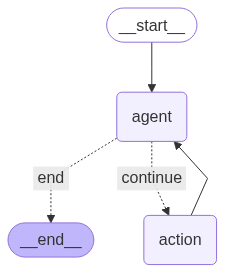

In [87]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Testing with Prompt

In [88]:
graph.invoke(
    {
        "messages": [
            HumanMessage(
                "What value you get when you add 3.4 and Subtract 5 from 15.64"
            )
        ]
    }
)

{'messages': [HumanMessage(content='What value you get when you add 3.4 and Subtract 5 from 15.64', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'subtract', 'arguments': '{"y": 15.64, "x": 5.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--22a8194a-36d1-4de0-9339-57ef5c962a13-0', tool_calls=[{'name': 'add', 'args': {'y': 15.64, 'x': 3.4}, 'id': 'ef17cb87-ddf4-4deb-a98c-63b30c7faab3', 'type': 'tool_call'}, {'name': 'subtract', 'args': {'y': 15.64, 'x': 5.0}, 'id': 'df525093-64cf-4b37-b48d-602d55762866', 'type': 'tool_call'}], usage_metadata={'input_tokens': 106, 'output_tokens': 10, 'total_tokens': 116, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='19.04', tool_call_id='ef17cb87-ddf4-4deb-a98c-63b30c7faab3'),
  ToolMessage(content='10.64', tool_call_id='df525093-64cf-4b37-b48d-602d55762866'),
  AIMessage

In [89]:
graph.invoke(
    {
        "messages": [
            HumanMessage(
                "What value I get if I add 2 and mutiply 3 times 4"
            )
        ]
    }
)

{'messages': [HumanMessage(content='What value I get if I add 2 and mutiply 3 times 4', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"y": 12.0, "x": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--ab5f5c1f-7534-42f9-a178-f6e185fd83ec-0', tool_calls=[{'name': 'add', 'args': {'y': 12.0, 'x': 2.0}, 'id': 'e1c28637-0a26-46c7-b410-42ee9c6cbc02', 'type': 'tool_call'}], usage_metadata={'input_tokens': 102, 'output_tokens': 5, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='14.0', tool_call_id='e1c28637-0a26-46c7-b410-42ee9c6cbc02'),
  AIMessage(content='I get 14.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--6512ffde-d163-4640-9bb3-2dfce072074e-0', usag

In [90]:
graph_builder.add_edge(START, "chatbot")

In [91]:
graph = graph_builder.compile()

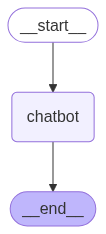

In [92]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass